## Comparing Parsl to Dask on a simple multicore system
This notebook compares Parsl and Dask on a trivial bag-of-task problem running on a ubuntu "data science" VM running on Azure.   the VM has 4 real cores (capable of 8 fully concurrent threads.)

The basic test is to compute pi 100 times using 1, 2, 4, 5, 10 and 100 concurrent tasks.  


In [2]:
#!pip install parsl

In [5]:
#!pip install "dask[bag]" --upgrade

In [1]:
import dask
import dask.bag as db

In [7]:
def do_pi(numpoints):
    from random import random
    inside = 0
    for i in range(numpoints):
        x, y = random(), random()  # Drop a random point in the box.
        if x**2 + y**2 < 1:        # Count points within the circle.
            inside += 1
    pi = inside*4 / numpoints
    return pi


compute pi with 10\*\*8 interation which is about the same work as 100 iterations of 10**6.

In [8]:
import time
t0 = time.time()
x = do_pi((10**6)*100)
print("pi =", x)
t1 =time.time()
print(t1-t0)

pi = 3.14137008
32.69071936607361


the function do_dask uses dask bags to express the concurrency.   we start with a list of 100 copies of the  value 10\*\*6.  next create a bag from this list and partition this bag into "nparts" partitions.  We use a lambda expression to map the elements of the bag to the do_pi function and then compute the mean of the values. 

In [4]:
import time

In [10]:
def do_dask(nparts):
    seq = [10**6 for i in range(100)]
    bagseq = db.from_sequence(seq, npartitions = nparts)
    t0 = time.time()
    c = bagseq.map(lambda x: do_pi(x)).mean()
    x =c.compute()
    t1 =time.time()
    print("time =", t1-t0)
    return t1-t0

We now run do task for different partition sizes.   if the partition size is x then there will be x threads assigned to the computation.

In [13]:
blocklist = [1, 2, 4, 5, 10, 20, 100]
dask_vals = []
for i in blocklist:
    dask_vals.append(do_dask(i))

time = 31.953450918197632
time = 16.490635633468628
time = 9.886584043502808
time = 10.630859375
time = 10.773289203643799
time = 9.673658847808838
time = 9.615858793258667


In [29]:
#!pip install "dask[distributed]" --upgrade

Dask also has a distributed package.   this will set up a cluster as snown below.

In [15]:
from dask.distributed import Client, progress, fire_and_forget

In [16]:
cl = Client()
cl

Client Scheduler: tcp://127.0.0.1:42849 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.68 GB


now if we partition our bag into 4 sets which is the same size as our cluster we can do the computation as follows.  the result is about the same as we saw above.

In [19]:
seq = [10**6 for i in range(100)]
bagseq = db.from_sequence(seq, npartitions = 4)
t0 = time.time()
x = cl.compute(bagseq.map(lambda x: do_pi(x)).mean())
while x.status != 'finished':
    time.sleep(.3)
#x =cl.compute(bs)
t1 = time.time()
print(x.result())
print(t1-t0)

3.14157128
10.221813678741455


## Parsl
For parsl we will use a local high throughput executor as configured below.   NOTE: this does not work on Windows10, but it is fine on our Azure ubuntu data science VM

In [14]:
from parsl import python_app
import parsl

In [15]:
from parsl.providers import LocalProvider
from parsl.channels import LocalChannel
from parsl.config import Config
from parsl.executors import HighThroughputExecutor

local_htex = Config(
    executors=[
        HighThroughputExecutor(
            label="htex_Local",
            worker_debug=True,
            cores_per_worker=1,
            provider=LocalProvider(
                channel=LocalChannel(),
                init_blocks=1,
                max_blocks=1,
            ),
        )
    ],
    strategy=None,
)

In [16]:
parsl.clear()

parsl.load(local_htex)


In [17]:
@python_app
def pi(numpoints):
    from random import random
    inside = 0
    for i in range(numpoints):
        x, y = random(), random()  # Drop a random point in the box.
        if x**2 + y**2 < 1:        # Count points within the circle.
            inside += 1
    pi = inside*4 / numpoints
    return pi


The following do_parsl function mirrors the do_dask function.    It divides the 100 tasks into chuncks of size blocks and repeats them 100/blocks times.   so if blocks == 1 then it is a sequential execution and if blocks == 100 the we fire off 100 pi funcitions and wait until they are all done.

In [18]:
def do_parsl(blocks):
    t1 = time.time()
    vals =  0
    for j in range(int(100/blocks)):
        clist = []
        for i in range(blocks):
            clist.append(pi(10**6))
        for i in range(blocks):
            vals += clist[i].result()
    t2 = time.time()
    print('total time=', t2-t1 ) 
    return t2-t1


In [19]:
blocklist = [1, 2, 4, 5, 10, 20, 100]
parsl_vals = []
for i in blocklist:
    parsl_vals.append(do_parsl(i))

total time= 36.0709707736969
total time= 18.033435106277466
total time= 12.502439737319946
total time= 10.998192071914673
total time= 15.645912647247314
total time= 15.29013180732727
total time= 15.73734736442566


In [20]:
parsl_vals

[36.0709707736969,
 18.033435106277466,
 12.502439737319946,
 10.998192071914673,
 15.645912647247314,
 15.29013180732727,
 15.73734736442566]

In [22]:
import matplotlib.pyplot as mp

Matplotlib is building the font cache; this may take a moment.


In [26]:
x = [1,2,3,4,5,6,7]

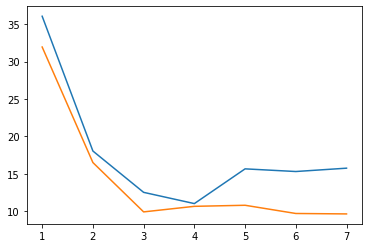

In [28]:
mp.plot(x, parsl_vals)
mp.plot(x, dask_vals)

In [26]:

parsl.clear()
#parsl.load(local_threads)
#parsl.load(local_htex)
parsl.load()

note: if you use the default parsl configuration there is no parallelism seen.

In [27]:
blocklist = [1, 2, 4, 5, 10, 20, 100]
parsl_vals = []
for i in blocklist:
    parsl_vals.append(do_parsl(i))

3.14162016
total time= 34.820037841796875
3.14131476
total time= 34.940215826034546
3.14147316
total time= 34.60612726211548
3.141513920000001
total time= 34.51739716529846
3.14124044
total time= 34.62702178955078
3.1416826800000006
total time= 35.31731939315796
3.14163308
total time= 34.94237017631531
